In [1]:
!nvidia-smi

Thu Aug  8 13:50:00 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0   175W / 250W |   8809MiB / 16280MiB |     76%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
%matplotlib inline
%load_ext autoreload
%autoreload 2
import tensorflow as tf
from tensorflow import keras

#import DataGenerator as DG
from DataGenerator import DataGenerator

import sklearn.metrics as metrics

import numpy as np
import random
import math
import os
import glob

import matplotlib.pyplot as plt

import h5py

In [3]:
###FIX NUMPY LOAD FOR DICTIONARIES
np_load_old = np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)
###Tensorflow session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

In [4]:
depth = 10

In [5]:
model_files=["model-2019-07-26-20:21:18.h5",
"model-2019-07-26-20:25:44.h5",
"model-2019-07-26-20:36:01.h5",
"model-2019-07-26-20:39:22.h5"]
use_single = True
single_model = "training-1-769/model_progress_03.h5"
#"model-2019-07-24-19:30:14.h5",
filepath = "images_synthetic_mouse.h5"

scratch_dir = "/mnt/disks/sec/Amit/"#"/n/scratch2/ap487/"
if not os.path.exists((scratch_dir+filepath)):
    copy(filepath,scratch_dir)
    print("File Copied to scratch directory")
filepath=scratch_dir+filepath
print("Using path: ",filepath)

Using path:  /mnt/disks/sec/Amit/images_synthetic_mouse.h5


In [6]:
def accuracy(predictions, answers, top_n=5):
    accs = np.zeros(len(answers))
    predicts = np.zeros(len(test_labels))
    for i in range(0,len(answers)):
        j = len(predictions[i])-1
        for k in range(0,top_n):
            if predictions[i][j-k]==answers[i]:
                accs[i]=1
                predicts[i]=predictions[i][j-k]
    return np.mean(accs), predicts

In [7]:
with h5py.File(filepath,'r') as f:
    amt = 70000
    print("Loading Test Data: " , amt)
    data_gen = DataGenerator(filepath,data_amount=amt,batch_size=int(math.floor(amt/depth)),frames_per_sample=depth,offset=800000,sliding_window=1)
    dat,lbl = data_gen.__getitem__(0)
    test_data=dat
    test_labels=lbl
    print("Test Data loaded")  

Loading Test Data:  70000
Test Data loaded


In [8]:
# make an ensemble prediction for multi-class classification
def ensemble_predictions(members, testX):
    # make predictions
    yhats = [model.predict(testX,verbose=1) for model in members]
    yhats = np.array(yhats)
    # sum across ensemble members
    summed = np.sum(yhats, axis=0)
    # argmax across classes
    result = np.argmax(summed, axis=1)
    return result

In [9]:
models = []
if use_single:
    models.append(keras.models.load_model(single_model))
else:
    for i in range(0, len(model_files)):
        models.append(keras.models.load_model(model_files[i]))

W0808 13:38:38.978892 140602014160704 deprecation.py:323] From /home/g17amitprasad_gmail_com/miniconda3/envs/tf2_gpu/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


7000/7000 [==============================] - 16s 2ms/sample
0.6315714285714286


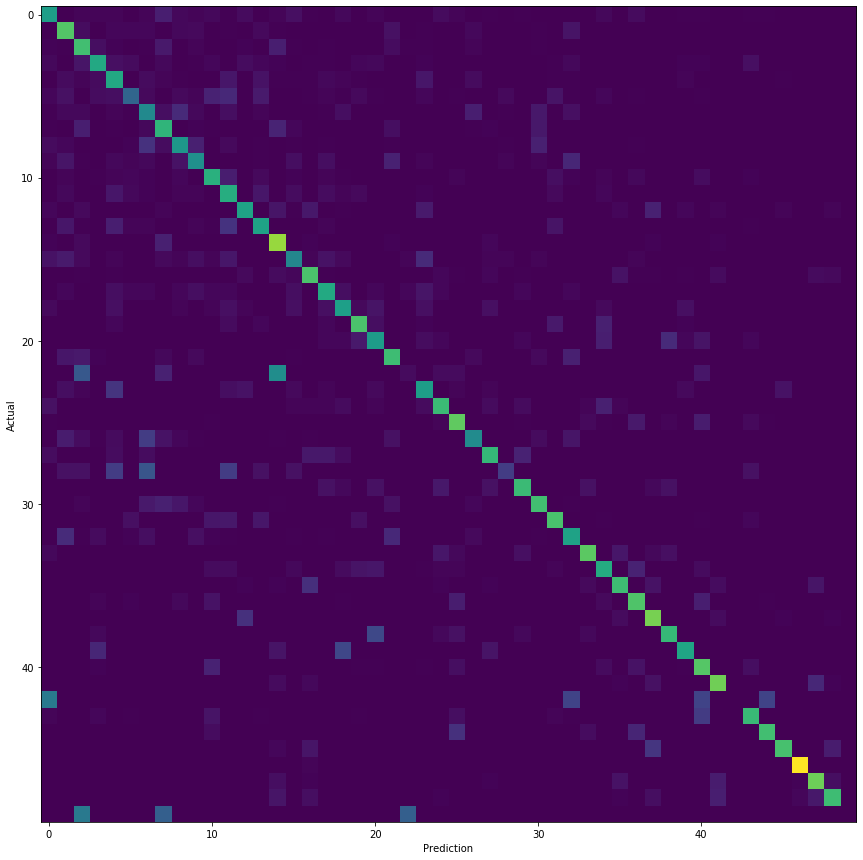

In [10]:
p=ensemble_predictions(models,test_data)
s = 0
for i in range(0,len(p)):
    if p[i]==test_labels[i]:
        s+=1
print(s/len(p))
conf_mat=metrics.confusion_matrix(test_labels,p)
conf_mat=conf_mat / conf_mat.astype(np.float).sum(axis=1,keepdims=True)
plt.rcParams["figure.figsize"] = (15,15)
plt.imshow(conf_mat)
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.show()

In [26]:
#model_benchmarks = np.load("benchmarks.npy")
#model_benchmarks.item()[name]=metrics.f1_score(test_labels,predicts,average=None)
#np.save("benchmarks.npy",model_benchmarks)
np.save("benchmarks/Ver1_1.npy",metrics.f1_score(test_labels,p,average=None))

/home/g17amitprasad_gmail_com/miniconda3/envs/tf2_gpu/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


benchmarks/2DCNN_F1.npy 0.24183018101606166
benchmarks/2DplusLSTMSliding2_F1.npy 0.6532559253604292
benchmarks/2DplusLSTMSliding3_F1.npy 0.5035154334506492
benchmarks/2DplusLSTMSliding_F1.npy 0.5741715312482969
benchmarks/3DCNNEnsemble_F1.npy 0.4396344778640909
benchmarks/3DCNNSingle_F1.npy 0.26015138299136553
benchmarks/training-0-1-485.npy 0.5779829731591992
benchmarks/training-0-2-486.npy 0.5789601434179816
benchmarks/training-1-1-490.npy 0.5824523397744615
benchmarks/training-0-4-488.npy 0.5906723362876455
benchmarks/training-0-0-484.npy 0.5797526252546653
benchmarks/training-1-2-491.npy 0.5882519822263584
benchmarks/training-1-0-489.npy 0.5894771847915068
benchmarks/training-1-3-492.npy 0.5890695991159415
benchmarks/training-0-3-487.npy 0.597503037458898
benchmarks/training-1-4-493.npy 0.588975910832004
benchmarks/training-2-0-494.npy 0.5506168505124115
benchmarks/training-2-1-495.npy 0.5936598076498616
benchmarks/training-2-2-496.npy 0.5722829146354205
benchmarks/training-2-3-497

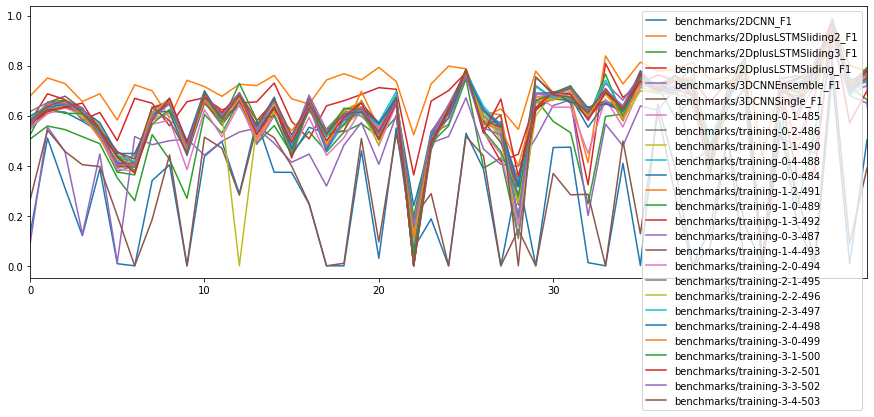

In [24]:
f1_paths = glob.glob("benchmarks/*.npy")
plt.rcParams["figure.figsize"] = (15,5)
for path in f1_paths:
    print(path + " " + str(np.mean(np.load(path))))
    plt.plot(np.load(path),label=path.split('.')[0])
plt.xlim(0,48)
plt.legend()
plt.show()

In [17]:
print(metrics.f1_score(test_labels,p,average=None))

[0.63304515 0.66894472 0.64937149 0.59936508 0.59215916 0.50403877
 0.61790581 0.64438356 0.49225754 0.6491063  0.68449728 0.61020093
 0.64979944 0.67173554 0.70071629 0.57694118 0.58853784 0.67217631
 0.69895432 0.7057072  0.72636263 0.66645669 0.28233151 0.64170616
 0.72123369 0.76871722 0.41629956 0.51218192 0.37625861 0.68643533
 0.64650956 0.64379947 0.30440967 0.82034771 0.66617321 0.76928983
 0.77303989 0.74889868 0.73215941 0.67352666 0.71544715 0.79731801
 0.0617284  0.68764045 0.4969697  0.58071279 0.95229603 0.76650682
 0.75846834 0.         0.         0.         0.         0.
 0.        ]


In [22]:
print(np.load("2DplusLSTM2Sliding_F1.npy"))

[0.01436782 0.07556193 0.04655327 0.02946955 0.03941385 0.00705467
 0.00280702 0.03042254 0.01244344 0.         0.02801462 0.00512383
 0.03666245 0.03424879 0.00628437 0.01973094 0.01975684 0.
 0.         0.01796407 0.         0.02148997 0.         0.01706161
 0.         0.02816901 0.01892473 0.         0.05113636 0.
 0.01748385 0.02754237 0.         0.         0.00963855 0.00272109
 0.03679369 0.04781533 0.         0.0056338  0.01031688 0.
 0.         0.04327666 0.         0.         0.08626198 0.
 0.00324675 0.         0.         0.        ]


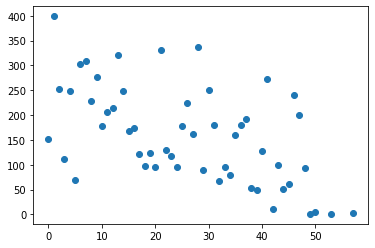

In [25]:
u=np.unique(test_labels,return_counts=True)
plt.scatter(u[0],u[1])
plt.show()

In [1]:
!nvidia-smi 

Failed to initialize NVML: Driver/library version mismatch
